# MultiETM

In this notebook, we show the complete workflow for MultiETM.

In [1]:
import sys
sys.path.append('../src/scETM/')  # For the sake of convenience, do this "improper" import to get the model directory

import os
os.environ[ 'NUMBA_CACHE_DIR' ] = '/scratch/st-jiaruid-1/yinian/tmp/' # https://github.com/scverse/scanpy/issues/2113

In [16]:
import yaml
from pathlib import Path
import pickle

import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [3]:
from batch_sampler import CellSamplerCITE
from models.multiETM import MultiETM
from trainers.UnsupervisedTrainerCITE import UnsupervisedTrainerCITE
from eval_utils import evaluate

### Load the experiment configuration file

In [4]:
config = yaml.safe_load(Path('../experiments/4_31800.yaml').read_text())
config

{'files': {'rna': ['/arc/project/st-jiaruid-1/yinian/pbmc/4_31800_raw_rna.h5ad'],
  'protein': ['/arc/project/st-jiaruid-1/yinian/pbmc/4_31800_raw_protein.h5ad'],
  'combined': ['/arc/project/st-jiaruid-1/yinian/pbmc/4_31800_raw_combined.h5ad'],
  'gene_indices': '/scratch/st-jiaruid-1/yinian/my_jupyter/scETM/scripts/gene_indices_2.pkl'},
 'model_params': {'n_epochs': 12000,
  'eval_every': 3000,
  'cell_type_col': 'cell_type',
  'day': 4,
  'donor': 31800,
  'rna_n_vars': 22085},
 'ckpt_dir': '/scratch/st-jiaruid-1/yinian/my_jupyter/scETM/results/'}

In [5]:
files = config['files']
model_params = config['model_params']
if model_params['cell_type_col'] == 'None':
    model_params['cell_type_col'] = None

### Load the data from the configuration

In [6]:
rna_files, protein_files = files['rna'], files['protein']
rna_adata = ad.concat([ad.read_h5ad(r_file) for r_file in rna_files], label="batch_indices")
protein_adata = ad.concat([ad.read_h5ad(p_file) for p_file in protein_files], label="batch_indices")

### Train the model

In [7]:
model = MultiETM(rna_adata.n_vars, protein_adata.n_vars, rna_adata.obs.batch_indices.nunique(), n_topics=25)
trainer = UnsupervisedTrainerCITE(model, rna_adata, protein_adata,
                                  ckpt_dir=os.path.join(config['ckpt_dir'], 'multiETM'))

n_batches == 1, disabling batch bias


In [9]:
trainer.train(
    n_epochs=model_params['n_epochs'],
    eval_every=model_params['eval_every'],
    eval_kwargs=dict(cell_type_col=model_params['cell_type_col']),
    n_samplers=1,
    save_model_ckpt=False
)

2023-04-17 14:52:22.199143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 14:52:37.158810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-04-17 14:52:37.159254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-04-17 14:52:37.159267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


### Evaluate the embeddings and clustering

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


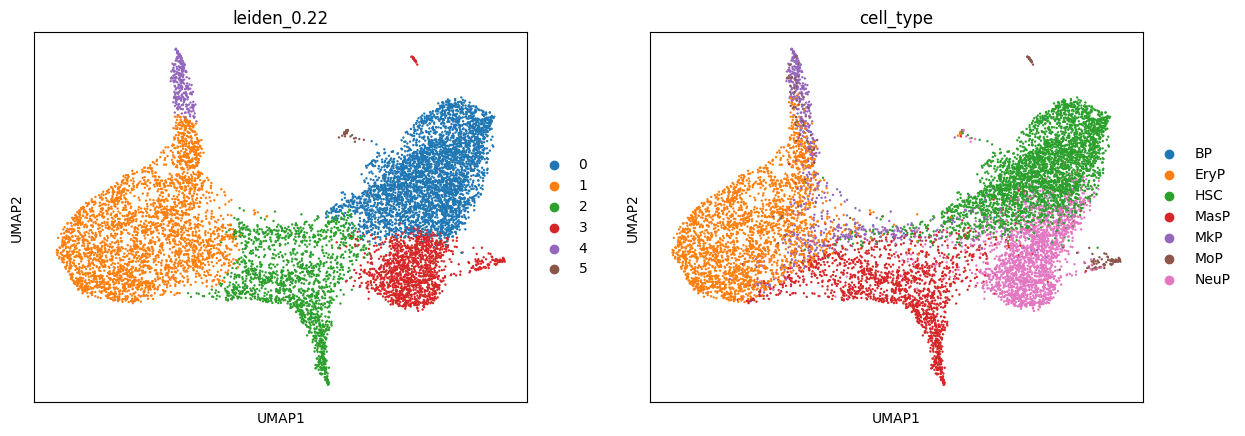

In [10]:
# resolutions = [0.20, 0.25, 0.32, 0.44, 0.50, 0.56, 0.64, 0.72, 0.88, 1, 1.21, 1.44]
resolutions = [0.1, 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.35, 0.44, 0.58, 0.72]
outputs, nll = model.get_all_embeddings_and_nll(rna_adata, protein_adata, inplace=False)
result = evaluate(
    rna_adata,
    resolutions=resolutions,
    return_fig=True,
    cell_type_col='cell_type',
    batch_col="batch_indices"
)

In [11]:
# The metrics on the optimal resolution
result

{'ari': 0.680586358653155,
 'nmi': 0.6436341001455868,
 'asw': 0.13126875,
 'ebm': None,
 'k_bet': None,
 'fig': <Figure size 1455.6x480 with 2 Axes>}

In [12]:
# Save the obs
rna_adata.write_csvs(trainer.ckpt_dir)

In [39]:
# Save the embeddings
with open(os.path.join(trainer.ckpt_dir, 'outputs.pkl'), 'wb') as f:
    pickle.dump(outputs, f)

### Analyze Delta

In [13]:
# alpha and rho
outputs['alpha'].shape, outputs['rho'].shape

((50, 400), (22225, 400))

In [14]:
topic_gene = outputs['alpha'] @ outputs['rho'].T
topic_gene.shape

(50, 22225)

In [15]:
gene_list = list(rna_adata.var_names)

### Top gene by topic heatmap

In [17]:
heatmap_arr = np.zeros((50, 250))
name_arr = []
real_name_arr = []

In [18]:
for i in range(50):
    gene_weights = list(topic_gene[i])
    s = sorted(zip(gene_weights, gene_list), reverse=True)
    for j in range(5):
        if s[j][1].find('_') >= 0:
            name = s[j][1][s[j][1].index('_')+1:]
        else:
            name = s[j][1]
        name_arr.append(name)
        real_name_arr.append(s[j][1])
real_name_arr = [gene_list.index(n) for n in real_name_arr]

In [19]:
for i in range(50):
    for j in range(250):
        heatmap_arr[i][j] = topic_gene[i, real_name_arr[j]]

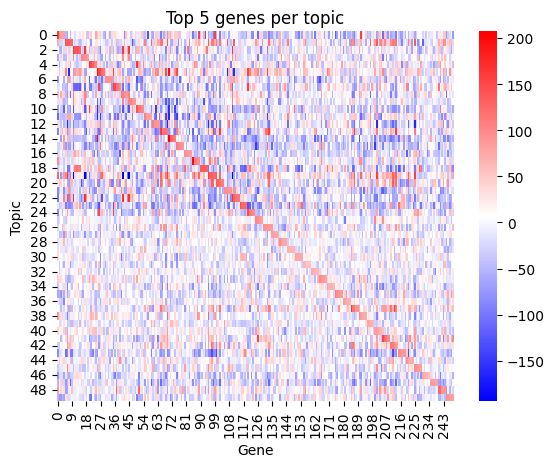

In [26]:
sns.heatmap(heatmap_arr,  cmap='bwr')
plt.xlabel('Gene')
plt.ylabel('Topic')
plt.title('Top 5 genes per topic')

plt.show()

### Cell by topic heatmap

In [35]:
clusters = sorted(list(set(rna_adata.obs['leiden_0.22'])))

In [36]:
deltas = []
categories = []
cell_colors = []
for c in clusters:
    c_adata = rna_adata[rna_adata.obs['leiden_0.22'] == c]
    deltas.append(c_adata.obsm['delta'])
    categories.extend([int(c) for i in range(c_adata.shape[0])])
    cell_colors.append(rna_adata.uns['leiden_0.22_colors'][int(c)])
heatmap_arr = np.concatenate(deltas).T

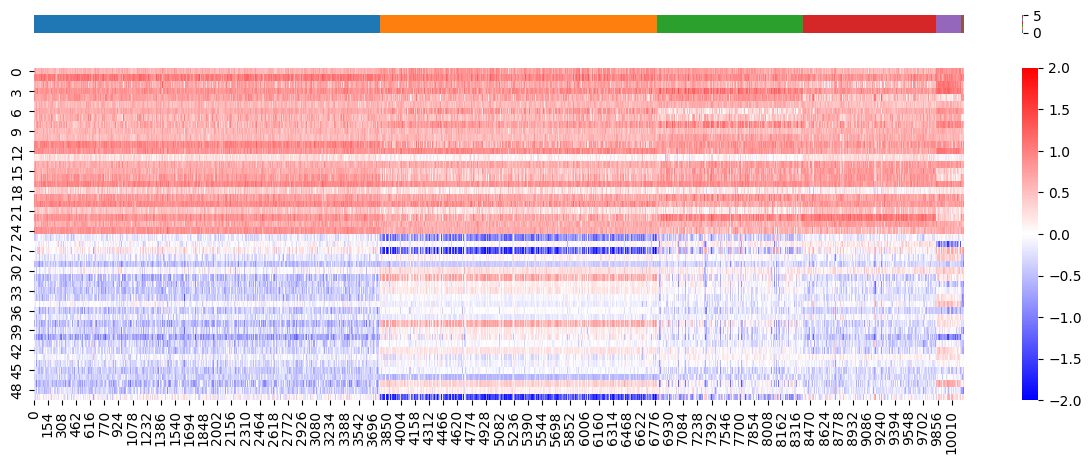

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), height_ratios=[0.05, 0.95])
sns.heatmap([categories], ax=ax1, cmap=cell_colors, xticklabels=False, yticklabels=False, cbar=True)
sns.heatmap(heatmap_arr, ax=ax2, vmin=-2, vmax=2, cmap='bwr')
plt.show()